In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import sklearn
from sklearn.preprocessing import StandardScaler
from torch import nn, tensor, no_grad, optim
from torch.utils.data import Dataset, DataLoader

In [2]:
def get_n_blocks(len_series: int, filter_size: int, base_dilation: int = 2) -> int:
    '''
    Function to determine the minimum number of residual blocks for full coverage of the input time series.
    
    Args:
        len_series: Length of the time series.
        filter_size: Filter size of the 1D convolutions of the TCN.
        base_dilation: Base of the dilation; for the i-th block of the TCN, it is supposed to be `base_dilation`**i.
        
    Returns:
        n_blocks: Minimum number of residual blocks for having full coverage of the input time series.
    '''
    if base_dilation == 2:
        log = np.log2(1 + (len_series - 1)/(2*(filter_size - 1)))
    else:
        log = np.log(1 + (len_series - 1)/(2*(filter_size - 1)))
        log /= np.log(base_dilation)
    #
    n_blocks = np.ceil(log)
    return int(n_blocks)

In [140]:
class ResidualBlock(nn.Module):
    def __init__(self, num_chan: int, dilation: int, dict_params: dict, last_block: bool,
                 gated_activation: bool = False) -> None:
        '''
        Residual block of the TCN.

        Args:
            num_chan: Number of features of the input time series. For a hidden layer, this is the number of filters of the previous one.
            dilation: Dilation factor.
            dict_params: Dictionary containing information about the model architecture.
            last_block: Whether it is the last residual block of the TCN.
            gated_activation: Whether to use gated (i.e., tanh*sigmoid) activation function; if false, relu is used.

        Returns: None.
        '''
        super().__init__()
        #
        filter_size = dict_params['filter_size']
        frac_dropout = dict_params['frac_dropout']
        num_filters = dict_params['num_filters']
        #
        self.padding = (filter_size - 1)*dilation
        self.last_block = last_block
        self.gated_activation = gated_activation
        # first convolution
        self.conv_1 = nn.Conv1d(in_channels = num_chan, out_channels = num_filters, kernel_size = filter_size,
                                dilation = dilation)
        self.conv_1 = nn.utils.parametrizations.weight_norm(self.conv_1)
        # second convolution
        self.conv_2 = nn.Conv1d(in_channels = num_filters, out_channels = num_filters, kernel_size = filter_size,
                                dilation = dilation)
        self.conv_2 = nn.utils.parametrizations.weight_norm(self.conv_2)
        # 1D convolution
        self.conv_1x1 = nn.Conv1d(in_channels = num_chan, out_channels = num_filters, kernel_size = 1)
        #
        self.relu = nn.ReLU()
        self.tanh = nn.Tanh()
        self.sigmoid = nn.Sigmoid()
        self.dropout = nn.Dropout(p = frac_dropout)
        
    def forward(self, x: tensor) -> tensor:
        y = self.conv_1(nn.functional.pad(x, (self.padding, 0)))
        if self.gated_activation == False:
            y = self.relu(y)
        else:
            y = self.tanh(y)*self.sigmoid(y)
        y = self.dropout(y)
        #
        y = self.conv_2(nn.functional.pad(y, (self.padding, 0)))
        if self.last_block == False:
            if self.gated_activation == False:
                y = self.relu(y)
            else:
                y = self.tanh(y)*self.sigmoid(y)
        y = self.dropout(y)
        #
        return self.conv_1x1(x) + y

class TCN(nn.Module):
    def __init__(self, len_series: int, num_feat: int, len_output: int, dict_params: dict, gated_activation: bool = False) -> None:
        '''
        TCN architecture.

        Args:
            len_series: Length of the input series.
            num_feat: Number of features of the input series.
            len_output: Length of the output series.
            dict_params: Dictionary containing information about the model architecture.
            gated_activation: Whether to use gated (i.e., tanh*sigmoid) activation function; if false, relu is used.

        Returns: None.
        '''
        super().__init__()
        #
        dict_params = dict_params['model']
        #
        filter_size = dict_params['filter_size']
        frac_dropout = dict_params['frac_dropout']
        base_dilation = dict_params['base_dilation']
        num_filters = dict_params['num_filters']
        self.len_output = len_output
        # get number of blocks
        n_blocks = get_n_blocks(len_series = len_series, filter_size = filter_size, base_dilation = base_dilation)
        # build TCN
        list_blocks = []
        for i in range(n_blocks):
            if i == 0:
                list_blocks.append(ResidualBlock(num_chan = num_feat, dilation = base_dilation**i, dict_params = dict_params,
                                                 last_block = False, gated_activation = gated_activation))
            elif 0 < i < n_blocks - 1:
                list_blocks.append(ResidualBlock(num_chan = num_filters, dilation = base_dilation**i, dict_params = dict_params,
                                                 last_block = False, gated_activation = gated_activation))
            else:
                list_blocks.append(ResidualBlock(num_chan = num_filters, dilation = base_dilation**i, dict_params = dict_params,
                                                 last_block = True, gated_activation = gated_activation))
        self.tcn = nn.ModuleList(list_blocks)
        # final convolutional layer, used to fix dimensions
        self.conv_final = nn.Conv1d(in_channels = num_filters, out_channels = 1, kernel_size = 1)
        
    def forward(self, x: tensor) -> tensor:
        # TCN
        y = self.tcn[0](x)
        if len(self.tcn) > 0:
            for i in range(1, len(self.tcn)):
                y = self.tcn[i](y)
        # final convolution
        y = self.conv_final(y[:, :, -self.len_output:])
        return y

In [329]:
dict_params = {'data': {'len_series': 20, 'size_train': 0.8, 'size_valid': 0.3, 'horizon_forecast': 5},
               'model': {'filter_size': 3, 'frac_dropout': 0.1, 'base_dilation': 2, 'num_filters': 30},
               'training': {'batch_size': 128, 'n_epochs': 300, 'patience': 50, 'min_improve_valid_loss': 0.005}}

,date,y,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_6,month_1,month_10,...,month_12,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,label
0,2010-01-07,1623.7,0,0,0,1,0,0,1,0,...,0,0,0,0,0,0,0,0,0,3
1,2010-01-08,1637.8,0,0,0,0,1,0,1,0,...,0,0,0,0,0,0,0,0,0,2
2,2010-01-10,1654.9,0,0,0,0,0,1,1,0,...,0,0,0,0,0,0,0,0,0,3
3,2010-01-11,1650.3,1,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,3
4,2010-01-12,1628.6,0,1,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,2


In [364]:
df = pd.read_csv('../../store-sales-time-series-forecasting/train.csv', parse_dates = ['date'], index_col = 'id')
df = df.groupby(['date', 'family']).agg({'sales': 'sum'}).reset_index()
# add all dates
df_temp = []
for family in df['family'].unique():
    df_temp.append(pd.DataFrame({'date': pd.date_range(df['date'].min(), df['date'].max())}).merge(df[df['family'] == family],
                                                                                                   on = 'date', how = 'left'))
    df_temp[-1]['family'] = family
    df_temp[-1]['sales'] = df_temp[-1]['sales'].ffill()
df = pd.concat(df_temp).reset_index(drop = True)
del df_temp
df = df.rename(columns = {'sales': 'y'})
#
df.head()

,date,family,y
0,2013-01-01,AUTOMOTIVE,0.0
1,2013-01-02,AUTOMOTIVE,255.0
2,2013-01-03,AUTOMOTIVE,161.0
3,2013-01-04,AUTOMOTIVE,169.0
4,2013-01-05,AUTOMOTIVE,342.0


In [381]:
def train_test_splitting(df: pd.DataFrame, dict_params: dict) -> (pd.DataFrame, pd.DataFrame, pd.DataFrame):
    '''
    Function to split data in training, validation and test set.

    Args:
        df: Dataframe containing time series. The column representing the main series should be called `y`.
        dict_params: Dictionary containing information about the model architecture.

    Returns:
        df_train: Dataframe corresponding to training set.
        df_valid: Dataframe corresponding to validation set.
        df_test: Dataframe corresponding to test set.
    '''
    df_train = df.iloc[:int(df.shape[0]*dict_params['data']['size_train'])].copy().reset_index(drop = True)
    df_test = df.iloc[int(df.shape[0]*dict_params['data']['size_train']):].reset_index(drop = True).copy().reset_index(drop = True)
    df_valid = df_train.iloc[int(df_train.shape[0]*(1 - dict_params['data']['size_valid'])):].copy().reset_index(drop = True)
    df_train = df_train.iloc[:int(df_train.shape[0]*(1 - dict_params['data']['size_valid']))].copy().reset_index(drop = True)
    # rescale data
    scaler = StandardScaler().fit(df_train[['y']])
    df_train[['y']] = scaler.transform(df_train[['y']])
    df_valid[['y']] = scaler.transform(df_valid[['y']])
    df_test[['y']] = scaler.transform(df_test[['y']])
    #
    return df_train, df_valid, df_test, scaler

In [273]:
def get_x_y(df: pd.DataFrame, df_future: pd.DataFrame, dict_params: dict, test_set: bool = False,
            horizon_forecast: int = None) -> (tensor, tensor, np.array, np.array):
    '''
    Function obtain a tensor of regressors and one of target series.

    Args:
        df: Dataframe containing time series. The column representing the main series should be called `y`.
        df_future: Same as `df`, but corresponding to its future (e.g., `df_valid` could be the "future" of `df_train`).
        dict_params: Dictionary containing information about the model architecture.
        test_set: Whether `df` is the dataframe corresponding to test set.
        horizon_forecast: Length of the series to be predicted.

    Returns:
        x: Tensor representing regressors.
        y: Tensor representing target time series.
        date_x: Array containing the dates corresponding to the elements of `x`.
        date_y: Array containing the dates corresponding to the elements of `y`.
    '''
    dict_params = dict_params['data']
    #
    len_series = dict_params['len_series']
    if (horizon_forecast is None) or (horizon_forecast >= len_series):
        horizon_forecast = len_series
    #
    df_present = df.copy()
    if test_set == False:
        df_future = pd.concat((df_present, df_future)).copy().shift(-len_series)
        df_future = df_future.iloc[:df_present.shape[0]].reset_index(drop = True)
    else:
        df_future = df_present.copy().shift(-len_series).dropna()
        df_present = df_present.iloc[:df_future.shape[0]]
    #
    x = np.array([df_present.loc[i: i + len_series - 1,
                                 [col for col in df_present.columns if col != 'date']].values for i in range(df_present.shape[0] - len_series)])
    y = np.array([df_future.loc[i: i + horizon_forecast - 1, ['y']].values for i in range(df_future.shape[0] - horizon_forecast)])
    date_x = np.array([df_present.loc[i: i + len_series - 1, 'date'].values for i in range(df_present.shape[0] - len_series)])
    date_y = np.array([df_future.loc[i: i + horizon_forecast - 1, 'date'].values for i in range(df_future.shape[0] - horizon_forecast)])
    #
    y = y[:x.shape[0]]
    date_y = date_y[:date_x.shape[0]]
    #
    x = tensor(x.astype(np.float32))
    y = tensor(y.astype(np.float32))
    #
    if len(x.shape) == 2:
        x = x.reshape(x.shape[0], 1, -1)
        y = y.reshape(y.shape[0], 1, -1)
        date_x = date_x.reshape(x.shape[0], 1, -1)
        date_y = date_y.reshape(y.shape[0], 1, -1)
    if len(x.shape) == 3:
        x = tensor(np.einsum('btc -> bct', x))
        y = tensor(np.einsum('btc -> bct', y))
        date_x = date_x.reshape(x.shape[0], 1, -1)
        date_y = date_y.reshape(y.shape[0], 1, -1)
    #
    return x, y, date_x, date_y

In [275]:
class CreateDataset(Dataset):
    def __init__(self, x: tensor, y: tensor):
        '''
        Class to create a PyTorch dataset
        
        Args:
            x: Tensor representing regressors.
            y: Tensor representing target time series.
            
        Returns: None.
        '''
        self.x = x
        self.y = y
        
    def __len__(self):
        return self.x.shape[0]
        
    def __getitem__(self, idx):
        x = self.x[idx]
        y = self.y[idx]
        return x, y

In [443]:
class TrainTCN():
    def __init__(self, model: torch.nn.Module, dict_params: dict, dataloader_train: torch.utils.data.DataLoader, dataloader_valid: torch.utils.data.DataLoader) -> None:
        '''
        Class to train the TCN model.
        
        Args:
            model: PyTorch model.
            dict_params: Dictionary containing information about the model architecture.
            dataloader_train: Dataloader containing training data.
            dataloader_valid: Dataloader containing validation data.
            
        Returns: None.
        '''
        self.model = model
        self.dict_params = dict_params
        self.dataloader_train = dataloader_train
        self.dataloader_valid = dataloader_valid
        #
        self.loss_func = nn.MSELoss()
        self.optimizer = optim.Adam(params = model.parameters(), lr = 1e-3)
        self.scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer = self.optimizer, mode = 'min', factor = 0.5,
                                                              patience = 10, threshold = 1e-4, threshold_mode = 'rel',
                                                              verbose = False)

    def _model_on_batch(self, batch: tuple, model: torch.nn.Module, optimizer: torch.optim, loss_func: torch.nn.modules.loss, perform_training: bool = True) -> float:
        '''
        Function to perform training on a single batch of data.
        
        Args:
            batch: Batch of data to use for training/evaluation.
            model: PyTorch model.
            optimizer: Optimizer to use.
            loss_func: Loss function to use.
            perform_training: Whether to perform training (if not, evaluation is understood).
            
        Returns:
            loss: Value of the loss function.
        '''
        if perform_training == True:
            optimizer.zero_grad()
        # get data from the batch
        x, y_true = batch
        x = x.to('cpu')
        y_true = y_true.to('cpu')
        # make predictions
        y_hat = model(x).to('cpu')
        # compute the loss function
        loss = loss_func(y_true, y_hat)
        if perform_training == True:
            loss.backward()
            optimizer.step()
        #
        return loss.item()

    def _train(self) -> float:
        '''
        Function to train the TCN model on a single epoch.
        
        Args: None.
            
        Returns:
            loss: Value of the training loss function per batch.
        '''
        model = self.model
        optimizer = self.optimizer
        loss_func = self.loss_func
        loader = self.dataloader_train
        #
        model.train()
        loss_epoch = 0
        # iterate over batches
        for batch in loader:
            loss_epoch += self._model_on_batch(batch = batch, model = model, optimizer = optimizer, loss_func = loss_func,
                                               perform_training = True)
        #
        return loss_epoch/len(loader)
    
    def _eval(self) -> float:
        '''
        Function to evaluate the TCN model on the validation set on a single epoch.
        
        Args: None.
            
        Returns:
            loss: Value of the validation loss function per batch.
        '''
        model = self.model
        loss_func = self.loss_func
        loader = self.dataloader_valid
        #
        model.eval()
        loss_epoch = 0
        # iterate over batches
        with no_grad():
            for batch in loader:
                loss_epoch += self._model_on_batch(batch = batch, model = model, optimizer = None, loss_func = loss_func,
                                                   perform_training = False)
        #
        return loss_epoch/len(loader)
    
    def train_model(self) -> (torch.nn.Module, list, list):
        '''
        Function to train the TCN model.
        
        Args: None.
            
        Returns:
            model: Trained TCN model.
            list_loss_train: List of training loss function across the epochs.
            list_loss_valid: List of validation loss function across the epochs.
        '''
        model = self.model
        dict_params = self.dict_params
        n_epochs = dict_params['training']['n_epochs']
        patience = dict_params['training']['patience']
        min_improve_valid_loss = dict_params['training']['min_improve_valid_loss']
        #
        list_loss_train, list_loss_valid = [], []
        counter_patience = 0
        for epoch in range(1, n_epochs + 1):
            loss_train = self._train()
            loss_valid = self._eval()
            # check validation loss improvement for patience
            if (len(list_loss_valid) > 0) and (loss_valid >= np.nanmin(list_loss_valid)*(1 - min_improve_valid_loss)):
                counter_patience += 1
            # check validation loss w.r.t. best value
            if (len(list_loss_valid) == 0) or (loss_valid < np.nanmin(list_loss_valid)):
                torch.save(self.model.state_dict(), '../data/artifacts/weights.p')
                counter_patience = 0
            # scheduler step
            self.scheduler.step(loss_valid)
            #
            print(f'Epoch {epoch}: training loss = {loss_train:.4f}, validation loss = {loss_valid:.4f}. ' +
                  f'Learning rate = {self.optimizer.param_groups[0]["lr"]}. Patience = {counter_patience}')
            #
            list_loss_train.append(loss_train)
            list_loss_valid.append(loss_valid)
            # stop training with patience
            if counter_patience >= patience:
                print(f'Training stopped at epoch {epoch}; restoring weights from epoch {np.argmin(list_loss_valid) + 1}')
                self.model.load_state_dict(torch.load('../data/artifacts/weights.p'))
                break
        #
        return model, list_loss_train, list_loss_valid

In [ ]:
def get_y_true_y_hat(model: torch.nn.Module, x: torch.tensor, y: torch.tensor, date_y: np.array,
                     scaler: sklearn.preprocessing.StandardScaler) -> (np.array, np.array):
    '''
    Function to get the real time series and its prediction.
    
    Args:
        model: Trained TCN model.
        x: Tensor representing regressors.
        y: Tensor representing target time series.
        date_y: Array containing the dates corresponding to the elements of `y`.
        scaler: Scaled used to rescale data.
        
    Returns:
        y_true: Array containing the true values.
        y_hat: Array containing the predicted values.
    '''
    list_date = []
    y_true = []
    y_hat = []
    preds = model(x)
    for i in range(np.unique(date_y).shape[0]):
        date = np.unique(date_y)[i]
        list_date.append(date)
        idx = np.where(date_y == date)
        y_true.append(y.numpy()[idx].mean())
        y_hat.append(preds.detach().numpy()[idx].mean())
    y_true = np.array(y_true)
    y_hat = np.array(y_hat)
    # scale back
    y_true = scaler.inverse_transform(y_true.reshape(-1, 1)).ravel()
    y_hat = scaler.inverse_transform(y_hat.reshape(-1, 1)).ravel()
    #
    return y_true, y_hat

In [452]:
def compute_mape(y_true: np.array, y_hat: np.array) -> float:
    '''
    Function to compute the MAPE.
    
    Args:
        y_true: Array containing the true values.
        y_hat: Array containing the predicted values.
        
    Returns:
        mape: MAPE computed from `y_true` and `y_hat`.
    '''
    mape = np.mean(abs(y_true[y_true > 0] - y_hat[y_true > 0])/y_true[y_true > 0])
    return mape

In [453]:
df_result = pd.DataFrame()
#
for family in df['family'].unique():
    # perform train-test splitting
    df_train, df_valid, df_test, scaler = train_test_splitting(df = df[df['family'] == family].reset_index(drop = True).drop('family', axis = 1),
                                                               dict_params = dict_params)
    #
    horizon_forecast = dict_params['data']['horizon_forecast']
    # training set data
    x_train, y_train, date_x_train, date_y_train = get_x_y(df = df_train, df_future = df_valid, dict_params = dict_params,
                                                           test_set = False, horizon_forecast = horizon_forecast)
    # validation set data
    x_valid, y_valid, date_x_valid, date_y_valid = get_x_y(df = df_valid, df_future = df_test, dict_params = dict_params,
                                                           test_set = False, horizon_forecast = horizon_forecast)
    # test set data
    x_test, y_test, date_x_test, date_y_test = get_x_y(df = df_test, df_future = None, dict_params = dict_params, test_set = True,
                                                       horizon_forecast = horizon_forecast)
    # create datasets and dataloader
    dataset_train = CreateDataset(x = x_train, y = y_train)
    dataset_valid = CreateDataset(x = x_valid, y = y_valid)
    dataloader_train = DataLoader(dataset_train, batch_size = dict_params['training']['batch_size'], shuffle = True)
    dataloader_valid = DataLoader(dataset_valid, batch_size = dict_params['training']['batch_size'], shuffle = False)
    # define the model
    if 'model' in locals():
        del model
    len_series = dataloader_train.dataset.x.shape[2]
    num_feat = dataloader_train.dataset.x.shape[1]
    len_output = dataloader_train.dataset.y.shape[2]
    # model = TCN(len_series = len_series, num_chan = num_chan, dict_params = dict_params, len_input=100, len_output = 7)
    model = TCN(len_series = len_series, num_feat = num_feat, len_output = len_output, dict_params = dict_params,
                gated_activation = False)
    # perform training
    model, list_loss_train, list_loss_valid = TrainTCN(model = model, dict_params = dict_params,
                                                       dataloader_train = dataloader_train,
                                                       dataloader_valid = dataloader_valid).train_model()
    # load best parameters
    if 'model' in locals():
        del model
    len_series = dataloader_train.dataset.x.shape[2]
    num_feat = dataloader_train.dataset.x.shape[1]
    len_output = dataloader_train.dataset.y.shape[2]
    # model = TCN(len_series = len_series, num_chan = num_chan, dict_params = dict_params, len_input=100, len_output = 7)
    model = TCN(len_series = len_series, num_feat = num_feat, len_output = len_output, dict_params = dict_params,
                gated_activation = False)
    #
    model.load_state_dict(torch.load('../data/artifacts/weights.p'))
    model.eval()
    # get time series and the corresponding predictions
    y_true_train, y_hat_train = get_y_true_y_hat(model = model, x = x_train, y = y_train, date_y = date_y_train, scaler = scaler)
    y_true_valid, y_hat_valid = get_y_true_y_hat(model = model, x = x_valid, y = y_valid, date_y = date_y_valid, scaler = scaler)
    y_true_test, y_hat_test = get_y_true_y_hat(model = model, x = x_test, y = y_test, date_y = date_y_test, scaler = scaler)
    # compute mape on training, validation and test set
    mape_train = compute_mape(y_true = y_true_train, y_hat = y_hat_train)
    mape_valid = compute_mape(y_true = y_true_valid, y_hat = y_hat_valid)
    mape_test = compute_mape(y_true = y_true_test, y_hat = y_hat_test)
    #
    df_result = pd.concat((df_result, pd.DataFrame({'family': [family], 'mape_train': [mape_train], 'mape_valid': [mape_valid],
                                                    'mape_test': [mape_test]})))
#
df_result = df_result.reset_index(drop = True)

Epoch 1: training loss = 0.7887, validation loss = 1.2967. Learning rate = 0.001. Patience = 0
Epoch 2: training loss = 0.4731, validation loss = 0.8211. Learning rate = 0.001. Patience = 0
Epoch 3: training loss = 0.4235, validation loss = 0.7362. Learning rate = 0.001. Patience = 0
Epoch 4: training loss = 0.3863, validation loss = 0.7240. Learning rate = 0.001. Patience = 0
Epoch 5: training loss = 0.3640, validation loss = 0.7037. Learning rate = 0.001. Patience = 0
Epoch 6: training loss = 0.3614, validation loss = 0.7114. Learning rate = 0.001. Patience = 1
Epoch 7: training loss = 0.3627, validation loss = 0.6925. Learning rate = 0.001. Patience = 0
Epoch 8: training loss = 0.3566, validation loss = 0.6766. Learning rate = 0.001. Patience = 0
Epoch 9: training loss = 0.3381, validation loss = 0.7363. Learning rate = 0.001. Patience = 1
Epoch 10: training loss = 0.3401, validation loss = 0.6844. Learning rate = 0.001. Patience = 2
Epoch 11: training loss = 0.3237, validation loss

Epoch 12: training loss = 2.0981, validation loss = 4.3449. Learning rate = 0.0005. Patience = 11
Epoch 13: training loss = 1.2506, validation loss = 4.9185. Learning rate = 0.0005. Patience = 12
Epoch 14: training loss = 1.2310, validation loss = 4.5799. Learning rate = 0.0005. Patience = 13
Epoch 15: training loss = 1.2450, validation loss = 4.6095. Learning rate = 0.0005. Patience = 14
Epoch 16: training loss = 2.0206, validation loss = 4.9123. Learning rate = 0.0005. Patience = 15
Epoch 17: training loss = 1.2217, validation loss = 5.8826. Learning rate = 0.0005. Patience = 16
Epoch 18: training loss = 1.2321, validation loss = 5.1921. Learning rate = 0.0005. Patience = 17
Epoch 19: training loss = 1.2546, validation loss = 5.1762. Learning rate = 0.0005. Patience = 18
Epoch 20: training loss = 1.1765, validation loss = 5.2705. Learning rate = 0.0005. Patience = 19
Epoch 21: training loss = 1.1720, validation loss = 5.6132. Learning rate = 0.0005. Patience = 20
Epoch 22: training l

Epoch 44: training loss = 0.3321, validation loss = 2.4544. Learning rate = 0.000125. Patience = 36
Epoch 45: training loss = 0.3246, validation loss = 2.3790. Learning rate = 0.000125. Patience = 37
Epoch 46: training loss = 0.3184, validation loss = 2.4105. Learning rate = 0.000125. Patience = 38
Epoch 47: training loss = 0.3094, validation loss = 2.4041. Learning rate = 0.000125. Patience = 39
Epoch 48: training loss = 0.3147, validation loss = 2.4735. Learning rate = 0.000125. Patience = 40
Epoch 49: training loss = 0.3149, validation loss = 2.4181. Learning rate = 0.000125. Patience = 41
Epoch 50: training loss = 0.3055, validation loss = 2.4266. Learning rate = 0.000125. Patience = 42
Epoch 51: training loss = 0.3196, validation loss = 2.5606. Learning rate = 0.000125. Patience = 43
Epoch 52: training loss = 0.3063, validation loss = 2.5111. Learning rate = 6.25e-05. Patience = 44
Epoch 53: training loss = 0.3114, validation loss = 2.4902. Learning rate = 6.25e-05. Patience = 45


Epoch 70: training loss = 0.1934, validation loss = 0.4303. Learning rate = 0.000125. Patience = 39
Epoch 71: training loss = 0.1978, validation loss = 0.4320. Learning rate = 0.000125. Patience = 40
Epoch 72: training loss = 0.2000, validation loss = 0.4345. Learning rate = 0.000125. Patience = 41
Epoch 73: training loss = 0.1868, validation loss = 0.4285. Learning rate = 0.000125. Patience = 42
Epoch 74: training loss = 0.1999, validation loss = 0.4382. Learning rate = 0.000125. Patience = 43
Epoch 75: training loss = 0.1912, validation loss = 0.4523. Learning rate = 6.25e-05. Patience = 44
Epoch 76: training loss = 0.2046, validation loss = 0.4478. Learning rate = 6.25e-05. Patience = 45
Epoch 77: training loss = 0.1925, validation loss = 0.4349. Learning rate = 6.25e-05. Patience = 46
Epoch 78: training loss = 0.2043, validation loss = 0.4317. Learning rate = 6.25e-05. Patience = 47
Epoch 79: training loss = 0.2197, validation loss = 0.4368. Learning rate = 6.25e-05. Patience = 48


Epoch 73: training loss = 0.0000, validation loss = 0.0000. Learning rate = 0.00025. Patience = 18
Epoch 74: training loss = 0.0000, validation loss = 0.0000. Learning rate = 0.00025. Patience = 19
Epoch 75: training loss = 0.0000, validation loss = 0.0000. Learning rate = 0.00025. Patience = 20
Epoch 76: training loss = 0.0000, validation loss = 0.0000. Learning rate = 0.00025. Patience = 21
Epoch 77: training loss = 0.0000, validation loss = 0.0000. Learning rate = 0.000125. Patience = 22
Epoch 78: training loss = 0.0000, validation loss = 0.0000. Learning rate = 0.000125. Patience = 23
Epoch 79: training loss = 0.0000, validation loss = 0.0000. Learning rate = 0.000125. Patience = 24
Epoch 80: training loss = 0.0000, validation loss = 0.0000. Learning rate = 0.000125. Patience = 25
Epoch 81: training loss = 0.0000, validation loss = 0.0000. Learning rate = 0.000125. Patience = 26
Epoch 82: training loss = 0.0000, validation loss = 0.0000. Learning rate = 0.000125. Patience = 27
Epoc

C:\Users\alled\anaconda3\envs\trading\lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\alled\anaconda3\envs\trading\lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\alled\anaconda3\envs\trading\lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\alled\anaconda3\envs\trading\lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


Epoch 1: training loss = 0.8555, validation loss = 1.0442. Learning rate = 0.001. Patience = 0
Epoch 2: training loss = 0.4521, validation loss = 0.6214. Learning rate = 0.001. Patience = 0
Epoch 3: training loss = 0.3083, validation loss = 0.5129. Learning rate = 0.001. Patience = 0
Epoch 4: training loss = 0.2619, validation loss = 0.3946. Learning rate = 0.001. Patience = 0
Epoch 5: training loss = 0.2366, validation loss = 0.3659. Learning rate = 0.001. Patience = 0
Epoch 6: training loss = 0.2352, validation loss = 0.3499. Learning rate = 0.001. Patience = 0
Epoch 7: training loss = 0.2203, validation loss = 0.3469. Learning rate = 0.001. Patience = 0
Epoch 8: training loss = 0.2247, validation loss = 0.3374. Learning rate = 0.001. Patience = 0
Epoch 9: training loss = 0.2399, validation loss = 0.3097. Learning rate = 0.001. Patience = 0
Epoch 10: training loss = 0.2153, validation loss = 0.3194. Learning rate = 0.001. Patience = 1
Epoch 11: training loss = 0.2185, validation loss

Epoch 85: training loss = 0.1624, validation loss = 0.2784. Learning rate = 3.125e-05. Patience = 44
Epoch 86: training loss = 0.1654, validation loss = 0.2757. Learning rate = 3.125e-05. Patience = 45
Epoch 87: training loss = 0.1686, validation loss = 0.2736. Learning rate = 3.125e-05. Patience = 46
Epoch 88: training loss = 0.1596, validation loss = 0.2754. Learning rate = 3.125e-05. Patience = 47
Epoch 89: training loss = 0.1651, validation loss = 0.2770. Learning rate = 3.125e-05. Patience = 48
Epoch 90: training loss = 0.1653, validation loss = 0.2796. Learning rate = 3.125e-05. Patience = 49
Epoch 91: training loss = 0.1578, validation loss = 0.2745. Learning rate = 3.125e-05. Patience = 50
Training stopped at epoch 91; restoring weights from epoch 41
Epoch 1: training loss = 0.6273, validation loss = 0.6060. Learning rate = 0.001. Patience = 0
Epoch 2: training loss = 0.4560, validation loss = 0.6149. Learning rate = 0.001. Patience = 1
Epoch 3: training loss = 0.3607, validati

Epoch 8: training loss = 0.4006, validation loss = 0.5465. Learning rate = 0.001. Patience = 0
Epoch 9: training loss = 0.3646, validation loss = 0.5557. Learning rate = 0.001. Patience = 1
Epoch 10: training loss = 0.3770, validation loss = 0.5167. Learning rate = 0.001. Patience = 0
Epoch 11: training loss = 0.3835, validation loss = 0.5025. Learning rate = 0.001. Patience = 0
Epoch 12: training loss = 0.3407, validation loss = 0.5961. Learning rate = 0.001. Patience = 1
Epoch 13: training loss = 0.3430, validation loss = 0.5022. Learning rate = 0.001. Patience = 0
Epoch 14: training loss = 0.3333, validation loss = 0.4964. Learning rate = 0.001. Patience = 0
Epoch 15: training loss = 0.3567, validation loss = 0.5075. Learning rate = 0.001. Patience = 1
Epoch 16: training loss = 0.3165, validation loss = 0.4967. Learning rate = 0.001. Patience = 2
Epoch 17: training loss = 0.3052, validation loss = 0.5215. Learning rate = 0.001. Patience = 3
Epoch 18: training loss = 0.3101, validati

Epoch 14: training loss = 0.1565, validation loss = 0.3372. Learning rate = 0.001. Patience = 10
Epoch 15: training loss = 0.1553, validation loss = 0.3491. Learning rate = 0.0005. Patience = 11
Epoch 16: training loss = 0.1499, validation loss = 0.3314. Learning rate = 0.0005. Patience = 12
Epoch 17: training loss = 0.1518, validation loss = 0.3525. Learning rate = 0.0005. Patience = 13
Epoch 18: training loss = 0.1457, validation loss = 0.3387. Learning rate = 0.0005. Patience = 14
Epoch 19: training loss = 0.1490, validation loss = 0.3345. Learning rate = 0.0005. Patience = 15
Epoch 20: training loss = 0.1543, validation loss = 0.3475. Learning rate = 0.0005. Patience = 16
Epoch 21: training loss = 0.1536, validation loss = 0.3212. Learning rate = 0.0005. Patience = 17
Epoch 22: training loss = 0.1521, validation loss = 0.3381. Learning rate = 0.0005. Patience = 18
Epoch 23: training loss = 0.1442, validation loss = 0.3297. Learning rate = 0.0005. Patience = 19
Epoch 24: training lo

Epoch 45: training loss = 0.1867, validation loss = 0.3488. Learning rate = 0.0005. Patience = 0
Epoch 46: training loss = 0.1911, validation loss = 0.3495. Learning rate = 0.0005. Patience = 1
Epoch 47: training loss = 0.1908, validation loss = 0.3583. Learning rate = 0.0005. Patience = 2
Epoch 48: training loss = 0.1831, validation loss = 0.3536. Learning rate = 0.0005. Patience = 3
Epoch 49: training loss = 0.1891, validation loss = 0.3541. Learning rate = 0.0005. Patience = 4
Epoch 50: training loss = 0.1890, validation loss = 0.3513. Learning rate = 0.0005. Patience = 5
Epoch 51: training loss = 0.1940, validation loss = 0.3646. Learning rate = 0.0005. Patience = 6
Epoch 52: training loss = 0.1823, validation loss = 0.3596. Learning rate = 0.0005. Patience = 7
Epoch 53: training loss = 0.1792, validation loss = 0.3664. Learning rate = 0.0005. Patience = 8
Epoch 54: training loss = 0.1823, validation loss = 0.3603. Learning rate = 0.0005. Patience = 9
Epoch 55: training loss = 0.17

Epoch 33: training loss = 0.1999, validation loss = 0.2602. Learning rate = 0.0005. Patience = 18
Epoch 34: training loss = 0.2002, validation loss = 0.2627. Learning rate = 0.0005. Patience = 19
Epoch 35: training loss = 0.1971, validation loss = 0.2656. Learning rate = 0.0005. Patience = 20
Epoch 36: training loss = 0.2063, validation loss = 0.2584. Learning rate = 0.0005. Patience = 21
Epoch 37: training loss = 0.2004, validation loss = 0.2570. Learning rate = 0.00025. Patience = 22
Epoch 38: training loss = 0.1979, validation loss = 0.2559. Learning rate = 0.00025. Patience = 23
Epoch 39: training loss = 0.2001, validation loss = 0.2633. Learning rate = 0.00025. Patience = 24
Epoch 40: training loss = 0.2007, validation loss = 0.2623. Learning rate = 0.00025. Patience = 25
Epoch 41: training loss = 0.1987, validation loss = 0.2597. Learning rate = 0.00025. Patience = 26
Epoch 42: training loss = 0.1905, validation loss = 0.2625. Learning rate = 0.00025. Patience = 27
Epoch 43: trai

Epoch 53: training loss = 0.0610, validation loss = 0.6806. Learning rate = 0.00025. Patience = 27
Epoch 54: training loss = 0.0783, validation loss = 0.6986. Learning rate = 0.00025. Patience = 28
Epoch 55: training loss = 0.0628, validation loss = 0.7330. Learning rate = 0.00025. Patience = 29
Epoch 56: training loss = 0.0692, validation loss = 0.7419. Learning rate = 0.00025. Patience = 30
Epoch 57: training loss = 0.0771, validation loss = 0.7280. Learning rate = 0.00025. Patience = 31
Epoch 58: training loss = 0.0584, validation loss = 0.7138. Learning rate = 0.00025. Patience = 32
Epoch 59: training loss = 0.0632, validation loss = 0.7664. Learning rate = 0.000125. Patience = 33
Epoch 60: training loss = 0.0630, validation loss = 0.7530. Learning rate = 0.000125. Patience = 34
Epoch 61: training loss = 0.0677, validation loss = 0.7454. Learning rate = 0.000125. Patience = 35
Epoch 62: training loss = 0.0637, validation loss = 0.7367. Learning rate = 0.000125. Patience = 36
Epoch 

Epoch 7: training loss = 0.4399, validation loss = 0.7284. Learning rate = 0.001. Patience = 0
Epoch 8: training loss = 0.4976, validation loss = 0.7325. Learning rate = 0.001. Patience = 1
Epoch 9: training loss = 0.4142, validation loss = 0.7083. Learning rate = 0.001. Patience = 0
Epoch 10: training loss = 0.4005, validation loss = 0.7060. Learning rate = 0.001. Patience = 0
Epoch 11: training loss = 0.3847, validation loss = 0.6869. Learning rate = 0.001. Patience = 0
Epoch 12: training loss = 0.3708, validation loss = 0.6946. Learning rate = 0.001. Patience = 1
Epoch 13: training loss = 0.3660, validation loss = 0.6780. Learning rate = 0.001. Patience = 0
Epoch 14: training loss = 0.3593, validation loss = 0.6830. Learning rate = 0.001. Patience = 1
Epoch 15: training loss = 0.3892, validation loss = 0.6773. Learning rate = 0.001. Patience = 0
Epoch 16: training loss = 0.3564, validation loss = 0.6559. Learning rate = 0.001. Patience = 0
Epoch 17: training loss = 0.3542, validatio

Epoch 92: training loss = 0.1922, validation loss = 0.5378. Learning rate = 0.000125. Patience = 14
Epoch 93: training loss = 0.2147, validation loss = 0.5359. Learning rate = 0.000125. Patience = 15
Epoch 94: training loss = 0.1786, validation loss = 0.5327. Learning rate = 0.000125. Patience = 16
Epoch 95: training loss = 0.1841, validation loss = 0.5365. Learning rate = 0.000125. Patience = 17
Epoch 96: training loss = 0.1893, validation loss = 0.5414. Learning rate = 0.000125. Patience = 18
Epoch 97: training loss = 0.1818, validation loss = 0.5418. Learning rate = 0.000125. Patience = 19
Epoch 98: training loss = 0.1911, validation loss = 0.5397. Learning rate = 0.000125. Patience = 20
Epoch 99: training loss = 0.1812, validation loss = 0.5414. Learning rate = 0.000125. Patience = 21
Epoch 100: training loss = 0.1872, validation loss = 0.5379. Learning rate = 6.25e-05. Patience = 22
Epoch 101: training loss = 0.1802, validation loss = 0.5379. Learning rate = 6.25e-05. Patience = 2

Epoch 46: training loss = 0.4973, validation loss = 0.9278. Learning rate = 6.25e-05. Patience = 44
Epoch 47: training loss = 0.4920, validation loss = 0.9276. Learning rate = 6.25e-05. Patience = 45
Epoch 48: training loss = 0.4909, validation loss = 0.9301. Learning rate = 6.25e-05. Patience = 46
Epoch 49: training loss = 0.4816, validation loss = 0.9295. Learning rate = 6.25e-05. Patience = 47
Epoch 50: training loss = 0.5069, validation loss = 0.9324. Learning rate = 6.25e-05. Patience = 48
Epoch 51: training loss = 0.4918, validation loss = 0.9327. Learning rate = 6.25e-05. Patience = 49
Epoch 52: training loss = 0.5055, validation loss = 0.9322. Learning rate = 6.25e-05. Patience = 50
Training stopped at epoch 52; restoring weights from epoch 2
Epoch 1: training loss = 0.8541, validation loss = 0.3981. Learning rate = 0.001. Patience = 0
Epoch 2: training loss = 0.3533, validation loss = 0.3889. Learning rate = 0.001. Patience = 0
Epoch 3: training loss = 0.3094, validation loss 

Epoch 6: training loss = 0.1853, validation loss = 0.7685. Learning rate = 0.001. Patience = 0
Epoch 7: training loss = 0.1739, validation loss = 0.7442. Learning rate = 0.001. Patience = 0
Epoch 8: training loss = 0.1625, validation loss = 0.7418. Learning rate = 0.001. Patience = 0
Epoch 9: training loss = 0.1664, validation loss = 0.7422. Learning rate = 0.001. Patience = 1
Epoch 10: training loss = 0.1592, validation loss = 0.7438. Learning rate = 0.001. Patience = 2
Epoch 11: training loss = 0.1600, validation loss = 0.7462. Learning rate = 0.001. Patience = 3
Epoch 12: training loss = 0.1609, validation loss = 0.7455. Learning rate = 0.001. Patience = 4
Epoch 13: training loss = 0.1671, validation loss = 0.7471. Learning rate = 0.001. Patience = 5
Epoch 14: training loss = 0.1563, validation loss = 0.7556. Learning rate = 0.001. Patience = 6
Epoch 15: training loss = 0.1499, validation loss = 0.7745. Learning rate = 0.001. Patience = 7
Epoch 16: training loss = 0.1460, validation

Epoch 19: training loss = 0.3211, validation loss = 0.2589. Learning rate = 0.001. Patience = 5
Epoch 20: training loss = 0.3194, validation loss = 0.2517. Learning rate = 0.001. Patience = 6
Epoch 21: training loss = 0.3237, validation loss = 0.2460. Learning rate = 0.001. Patience = 0
Epoch 22: training loss = 0.3110, validation loss = 0.2478. Learning rate = 0.001. Patience = 1
Epoch 23: training loss = 0.3144, validation loss = 0.2496. Learning rate = 0.001. Patience = 2
Epoch 24: training loss = 0.3128, validation loss = 0.2664. Learning rate = 0.001. Patience = 3
Epoch 25: training loss = 0.3150, validation loss = 0.2484. Learning rate = 0.001. Patience = 4
Epoch 26: training loss = 0.3033, validation loss = 0.2511. Learning rate = 0.001. Patience = 5
Epoch 27: training loss = 0.3005, validation loss = 0.2520. Learning rate = 0.001. Patience = 6
Epoch 28: training loss = 0.3004, validation loss = 0.2618. Learning rate = 0.001. Patience = 7
Epoch 29: training loss = 0.3041, valida

Epoch 22: training loss = 0.2601, validation loss = 0.2308. Learning rate = 0.001. Patience = 0
Epoch 23: training loss = 0.2748, validation loss = 0.2404. Learning rate = 0.001. Patience = 1
Epoch 24: training loss = 0.2744, validation loss = 0.2738. Learning rate = 0.001. Patience = 2
Epoch 25: training loss = 0.2590, validation loss = 0.2365. Learning rate = 0.001. Patience = 3
Epoch 26: training loss = 0.2630, validation loss = 0.2378. Learning rate = 0.001. Patience = 4
Epoch 27: training loss = 0.2659, validation loss = 0.2760. Learning rate = 0.001. Patience = 5
Epoch 28: training loss = 0.2719, validation loss = 0.2288. Learning rate = 0.001. Patience = 0
Epoch 29: training loss = 0.2828, validation loss = 0.2817. Learning rate = 0.001. Patience = 1
Epoch 30: training loss = 0.2764, validation loss = 0.2538. Learning rate = 0.001. Patience = 2
Epoch 31: training loss = 0.2521, validation loss = 0.2437. Learning rate = 0.001. Patience = 3
Epoch 32: training loss = 0.2639, valida

Epoch 28: training loss = 0.2339, validation loss = 0.1763. Learning rate = 0.001. Patience = 2
Epoch 29: training loss = 0.2402, validation loss = 0.1740. Learning rate = 0.001. Patience = 3
Epoch 30: training loss = 0.2327, validation loss = 0.1883. Learning rate = 0.001. Patience = 4
Epoch 31: training loss = 0.2504, validation loss = 0.1786. Learning rate = 0.001. Patience = 5
Epoch 32: training loss = 0.2397, validation loss = 0.1839. Learning rate = 0.001. Patience = 6
Epoch 33: training loss = 0.2326, validation loss = 0.1761. Learning rate = 0.001. Patience = 7
Epoch 34: training loss = 0.2516, validation loss = 0.1807. Learning rate = 0.001. Patience = 8
Epoch 35: training loss = 0.2384, validation loss = 0.1856. Learning rate = 0.001. Patience = 9
Epoch 36: training loss = 0.2468, validation loss = 0.1752. Learning rate = 0.001. Patience = 10
Epoch 37: training loss = 0.2288, validation loss = 0.1813. Learning rate = 0.0005. Patience = 11
Epoch 38: training loss = 0.2337, val

Epoch 11: training loss = 0.3435, validation loss = 0.5305. Learning rate = 0.001. Patience = 2
Epoch 12: training loss = 0.3552, validation loss = 0.5550. Learning rate = 0.001. Patience = 3
Epoch 13: training loss = 0.3546, validation loss = 0.5054. Learning rate = 0.001. Patience = 0
Epoch 14: training loss = 0.3365, validation loss = 0.5030. Learning rate = 0.001. Patience = 0
Epoch 15: training loss = 0.3522, validation loss = 0.5292. Learning rate = 0.001. Patience = 1
Epoch 16: training loss = 0.3327, validation loss = 0.5405. Learning rate = 0.001. Patience = 2
Epoch 17: training loss = 0.3278, validation loss = 0.4668. Learning rate = 0.001. Patience = 0
Epoch 18: training loss = 0.3370, validation loss = 0.4934. Learning rate = 0.001. Patience = 1
Epoch 19: training loss = 0.3320, validation loss = 0.4647. Learning rate = 0.001. Patience = 0
Epoch 20: training loss = 0.3233, validation loss = 0.4824. Learning rate = 0.001. Patience = 1
Epoch 21: training loss = 0.3175, valida

Epoch 11: training loss = 0.4464, validation loss = 0.5558. Learning rate = 0.001. Patience = 2
Epoch 12: training loss = 0.4237, validation loss = 0.5336. Learning rate = 0.001. Patience = 0
Epoch 13: training loss = 0.4114, validation loss = 0.5521. Learning rate = 0.001. Patience = 1
Epoch 14: training loss = 0.4355, validation loss = 0.5527. Learning rate = 0.001. Patience = 2
Epoch 15: training loss = 0.4221, validation loss = 0.5441. Learning rate = 0.001. Patience = 3
Epoch 16: training loss = 0.4065, validation loss = 0.5500. Learning rate = 0.001. Patience = 4
Epoch 17: training loss = 0.4091, validation loss = 0.5303. Learning rate = 0.001. Patience = 0
Epoch 18: training loss = 0.3974, validation loss = 0.5356. Learning rate = 0.001. Patience = 1
Epoch 19: training loss = 0.3946, validation loss = 0.5331. Learning rate = 0.001. Patience = 2
Epoch 20: training loss = 0.3735, validation loss = 0.5316. Learning rate = 0.001. Patience = 3
Epoch 21: training loss = 0.3891, valida

Epoch 20: training loss = 0.2661, validation loss = 0.4168. Learning rate = 0.001. Patience = 1
Epoch 21: training loss = 0.2767, validation loss = 0.4127. Learning rate = 0.001. Patience = 2
Epoch 22: training loss = 0.2773, validation loss = 0.3921. Learning rate = 0.001. Patience = 0
Epoch 23: training loss = 0.2590, validation loss = 0.4130. Learning rate = 0.001. Patience = 1
Epoch 24: training loss = 0.2556, validation loss = 0.3979. Learning rate = 0.001. Patience = 2
Epoch 25: training loss = 0.2538, validation loss = 0.3985. Learning rate = 0.001. Patience = 3
Epoch 26: training loss = 0.2530, validation loss = 0.3859. Learning rate = 0.001. Patience = 0
Epoch 27: training loss = 0.2658, validation loss = 0.4195. Learning rate = 0.001. Patience = 1
Epoch 28: training loss = 0.2431, validation loss = 0.3782. Learning rate = 0.001. Patience = 0
Epoch 29: training loss = 0.2478, validation loss = 0.3929. Learning rate = 0.001. Patience = 1
Epoch 30: training loss = 0.2229, valida

Epoch 105: training loss = 0.1404, validation loss = 0.3495. Learning rate = 0.000125. Patience = 38
Epoch 106: training loss = 0.1445, validation loss = 0.3516. Learning rate = 0.000125. Patience = 39
Epoch 107: training loss = 0.1392, validation loss = 0.3501. Learning rate = 0.000125. Patience = 40
Epoch 108: training loss = 0.1369, validation loss = 0.3527. Learning rate = 0.000125. Patience = 41
Epoch 109: training loss = 0.1644, validation loss = 0.3526. Learning rate = 0.000125. Patience = 42
Epoch 110: training loss = 0.1486, validation loss = 0.3557. Learning rate = 0.000125. Patience = 43
Epoch 111: training loss = 0.1544, validation loss = 0.3526. Learning rate = 6.25e-05. Patience = 44
Epoch 112: training loss = 0.1493, validation loss = 0.3514. Learning rate = 6.25e-05. Patience = 45
Epoch 113: training loss = 0.1456, validation loss = 0.3515. Learning rate = 6.25e-05. Patience = 46
Epoch 114: training loss = 0.1426, validation loss = 0.3527. Learning rate = 6.25e-05. Pati

Epoch 20: training loss = 0.3762, validation loss = 0.5226. Learning rate = 0.001. Patience = 2
Epoch 21: training loss = 0.3601, validation loss = 0.5286. Learning rate = 0.001. Patience = 3
Epoch 22: training loss = 0.3512, validation loss = 0.5582. Learning rate = 0.001. Patience = 4
Epoch 23: training loss = 0.3611, validation loss = 0.5303. Learning rate = 0.001. Patience = 5
Epoch 24: training loss = 0.3608, validation loss = 0.5078. Learning rate = 0.001. Patience = 6
Epoch 25: training loss = 0.3434, validation loss = 0.5268. Learning rate = 0.001. Patience = 7
Epoch 26: training loss = 0.3435, validation loss = 0.5276. Learning rate = 0.001. Patience = 8
Epoch 27: training loss = 0.3442, validation loss = 0.5019. Learning rate = 0.001. Patience = 9
Epoch 28: training loss = 0.3324, validation loss = 0.5406. Learning rate = 0.001. Patience = 10
Epoch 29: training loss = 0.3487, validation loss = 0.5061. Learning rate = 0.0005. Patience = 11
Epoch 30: training loss = 0.3319, val

Epoch 36: training loss = 0.2497, validation loss = 0.8195. Learning rate = 0.0005. Patience = 17
Epoch 37: training loss = 0.2440, validation loss = 0.8344. Learning rate = 0.0005. Patience = 18
Epoch 38: training loss = 0.2487, validation loss = 0.7969. Learning rate = 0.0005. Patience = 19
Epoch 39: training loss = 0.2496, validation loss = 0.8537. Learning rate = 0.0005. Patience = 20
Epoch 40: training loss = 0.2452, validation loss = 0.8203. Learning rate = 0.0005. Patience = 21
Epoch 41: training loss = 0.2469, validation loss = 0.8625. Learning rate = 0.00025. Patience = 22
Epoch 42: training loss = 0.2453, validation loss = 0.8314. Learning rate = 0.00025. Patience = 23
Epoch 43: training loss = 0.2497, validation loss = 0.8377. Learning rate = 0.00025. Patience = 24
Epoch 44: training loss = 0.2352, validation loss = 0.8345. Learning rate = 0.00025. Patience = 25
Epoch 45: training loss = 0.2411, validation loss = 0.8287. Learning rate = 0.00025. Patience = 26
Epoch 46: train

Epoch 51: training loss = 0.2048, validation loss = 0.3304. Learning rate = 0.00025. Patience = 31
Epoch 52: training loss = 0.2080, validation loss = 0.3183. Learning rate = 0.00025. Patience = 32
Epoch 53: training loss = 0.2285, validation loss = 0.3386. Learning rate = 0.000125. Patience = 33
Epoch 54: training loss = 0.2124, validation loss = 0.3172. Learning rate = 0.000125. Patience = 34
Epoch 55: training loss = 0.2046, validation loss = 0.3281. Learning rate = 0.000125. Patience = 35
Epoch 56: training loss = 0.1984, validation loss = 0.3049. Learning rate = 0.000125. Patience = 36
Epoch 57: training loss = 0.2153, validation loss = 0.3225. Learning rate = 0.000125. Patience = 37
Epoch 58: training loss = 0.2156, validation loss = 0.3253. Learning rate = 0.000125. Patience = 38
Epoch 59: training loss = 0.2026, validation loss = 0.3152. Learning rate = 0.000125. Patience = 39
Epoch 60: training loss = 0.2181, validation loss = 0.3084. Learning rate = 0.000125. Patience = 40
Ep

Epoch 66: training loss = 0.2714, validation loss = 0.3193. Learning rate = 0.000125. Patience = 37
Epoch 67: training loss = 0.2489, validation loss = 0.3129. Learning rate = 0.000125. Patience = 38
Epoch 68: training loss = 0.2439, validation loss = 0.3122. Learning rate = 0.000125. Patience = 39
Epoch 69: training loss = 0.2427, validation loss = 0.3220. Learning rate = 0.000125. Patience = 40
Epoch 70: training loss = 0.2341, validation loss = 0.3196. Learning rate = 0.000125. Patience = 41
Epoch 71: training loss = 0.2427, validation loss = 0.3202. Learning rate = 0.000125. Patience = 42
Epoch 72: training loss = 0.2307, validation loss = 0.3116. Learning rate = 0.000125. Patience = 43
Epoch 73: training loss = 0.2684, validation loss = 0.3122. Learning rate = 6.25e-05. Patience = 44
Epoch 74: training loss = 0.2766, validation loss = 0.3136. Learning rate = 6.25e-05. Patience = 45
Epoch 75: training loss = 0.2475, validation loss = 0.3142. Learning rate = 6.25e-05. Patience = 46


Epoch 71: training loss = 0.1527, validation loss = 0.2219. Learning rate = 0.000125. Patience = 42
Epoch 72: training loss = 0.1482, validation loss = 0.2217. Learning rate = 0.000125. Patience = 43
Epoch 73: training loss = 0.1508, validation loss = 0.2205. Learning rate = 6.25e-05. Patience = 44
Epoch 74: training loss = 0.1542, validation loss = 0.2200. Learning rate = 6.25e-05. Patience = 45
Epoch 75: training loss = 0.1608, validation loss = 0.2198. Learning rate = 6.25e-05. Patience = 46
Epoch 76: training loss = 0.1446, validation loss = 0.2204. Learning rate = 6.25e-05. Patience = 47
Epoch 77: training loss = 0.1501, validation loss = 0.2206. Learning rate = 6.25e-05. Patience = 48
Epoch 78: training loss = 0.1426, validation loss = 0.2213. Learning rate = 6.25e-05. Patience = 49
Epoch 79: training loss = 0.1415, validation loss = 0.2208. Learning rate = 6.25e-05. Patience = 50
Training stopped at epoch 79; restoring weights from epoch 29
Epoch 1: training loss = 0.7767, valid

Epoch 75: training loss = 0.2760, validation loss = 0.3592. Learning rate = 6.25e-05. Patience = 29
Epoch 76: training loss = 0.2348, validation loss = 0.3630. Learning rate = 6.25e-05. Patience = 30
Epoch 77: training loss = 0.2444, validation loss = 0.3549. Learning rate = 6.25e-05. Patience = 31
Epoch 78: training loss = 0.2441, validation loss = 0.3568. Learning rate = 6.25e-05. Patience = 32
Epoch 79: training loss = 0.2484, validation loss = 0.3574. Learning rate = 3.125e-05. Patience = 33
Epoch 80: training loss = 0.2543, validation loss = 0.3588. Learning rate = 3.125e-05. Patience = 34
Epoch 81: training loss = 0.2416, validation loss = 0.3557. Learning rate = 3.125e-05. Patience = 35
Epoch 82: training loss = 0.2648, validation loss = 0.3540. Learning rate = 3.125e-05. Patience = 36
Epoch 83: training loss = 0.2391, validation loss = 0.3546. Learning rate = 3.125e-05. Patience = 37
Epoch 84: training loss = 0.2504, validation loss = 0.3554. Learning rate = 3.125e-05. Patience

Epoch 63: training loss = 0.2054, validation loss = 0.1339. Learning rate = 0.00025. Patience = 26
Epoch 64: training loss = 0.1983, validation loss = 0.1489. Learning rate = 0.00025. Patience = 27
Epoch 65: training loss = 0.2358, validation loss = 0.1428. Learning rate = 0.00025. Patience = 28
Epoch 66: training loss = 0.2231, validation loss = 0.1593. Learning rate = 0.00025. Patience = 29
Epoch 67: training loss = 0.2139, validation loss = 0.1404. Learning rate = 0.00025. Patience = 30
Epoch 68: training loss = 0.2413, validation loss = 0.1448. Learning rate = 0.00025. Patience = 31
Epoch 69: training loss = 0.2174, validation loss = 0.1653. Learning rate = 0.00025. Patience = 32
Epoch 70: training loss = 0.2025, validation loss = 0.1478. Learning rate = 0.000125. Patience = 33
Epoch 71: training loss = 0.1961, validation loss = 0.1447. Learning rate = 0.000125. Patience = 34
Epoch 72: training loss = 0.2155, validation loss = 0.1448. Learning rate = 0.000125. Patience = 35
Epoch 7

Epoch 1: training loss = 0.8930, validation loss = 0.8276. Learning rate = 0.001. Patience = 0
Epoch 2: training loss = 0.6104, validation loss = 0.5341. Learning rate = 0.001. Patience = 0
Epoch 3: training loss = 0.4816, validation loss = 0.4295. Learning rate = 0.001. Patience = 0
Epoch 4: training loss = 0.4631, validation loss = 0.3891. Learning rate = 0.001. Patience = 0
Epoch 5: training loss = 0.4234, validation loss = 0.3926. Learning rate = 0.001. Patience = 1
Epoch 6: training loss = 0.4165, validation loss = 0.3687. Learning rate = 0.001. Patience = 0
Epoch 7: training loss = 0.4043, validation loss = 0.3598. Learning rate = 0.001. Patience = 0
Epoch 8: training loss = 0.3963, validation loss = 0.3486. Learning rate = 0.001. Patience = 0
Epoch 9: training loss = 0.4025, validation loss = 0.3438. Learning rate = 0.001. Patience = 0
Epoch 10: training loss = 0.3927, validation loss = 0.3465. Learning rate = 0.001. Patience = 1
Epoch 11: training loss = 0.3928, validation loss

Epoch 86: training loss = 0.2492, validation loss = 0.3135. Learning rate = 6.25e-05. Patience = 42
Epoch 87: training loss = 0.2514, validation loss = 0.3155. Learning rate = 6.25e-05. Patience = 43
Epoch 88: training loss = 0.2466, validation loss = 0.3168. Learning rate = 3.125e-05. Patience = 44
Epoch 89: training loss = 0.2527, validation loss = 0.3166. Learning rate = 3.125e-05. Patience = 45
Epoch 90: training loss = 0.2452, validation loss = 0.3167. Learning rate = 3.125e-05. Patience = 46
Epoch 91: training loss = 0.2560, validation loss = 0.3167. Learning rate = 3.125e-05. Patience = 47
Epoch 92: training loss = 0.2510, validation loss = 0.3167. Learning rate = 3.125e-05. Patience = 48
Epoch 93: training loss = 0.2478, validation loss = 0.3164. Learning rate = 3.125e-05. Patience = 49
Epoch 94: training loss = 0.2494, validation loss = 0.3159. Learning rate = 3.125e-05. Patience = 50
Training stopped at epoch 94; restoring weights from epoch 44


In [458]:
df_result['mape_test'].max()

7999706.5

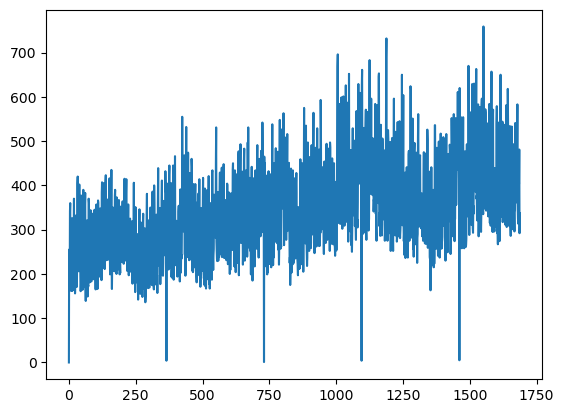

In [459]:
plt.figure()
plt.plot(df[df['family'] == 'AUTOMOTIVE']['y'])

In [409]:
list_date = []
list_y_true = []
list_y_hat = []
preds = model(x_test)
for i in range(np.unique(date_y_test).shape[0]):
    date = np.unique(date_y_test)[i]
    list_date.append(date)
    idx = np.where(date_y_test == date)
    list_y_true.append(y_test.numpy()[idx].mean())
    list_y_hat.append(preds.detach().numpy()[idx].mean())
list_y_true = np.array(list_y_true)
list_y_hat = np.array(list_y_hat)
# scale back
list_y_true = scaler.inverse_transform(list_y_true.reshape(-1, 1)).ravel()
list_y_hat = scaler.inverse_transform(list_y_hat.reshape(-1, 1)).ravel()

In [410]:
np.mean(abs(list_y_true[list_y_true > 0] - list_y_hat[list_y_true > 0])/list_y_hat[list_y_true > 0])

0.15152872

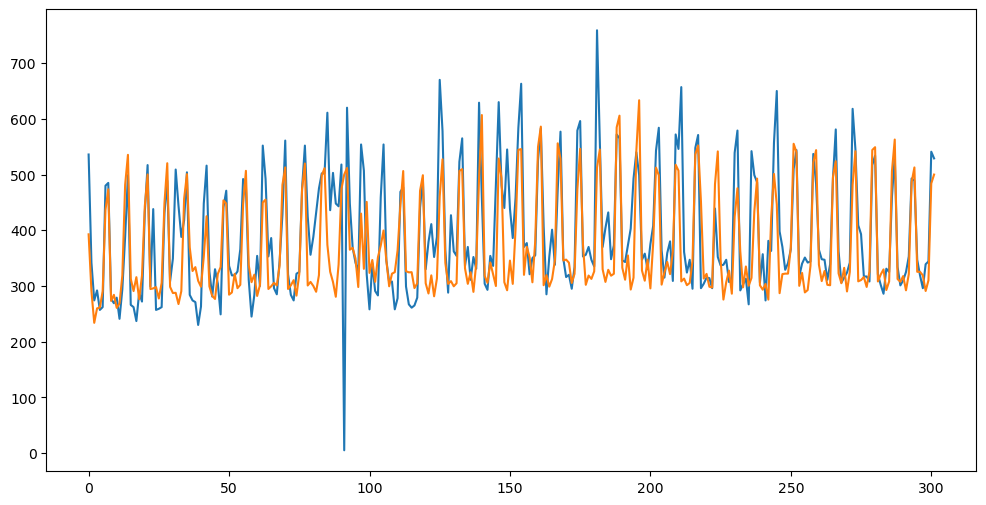

In [395]:
plt.figure(figsize = [12, 6])
plt.plot(list_y_true)
plt.plot(np.arange(len(list_y_hat)) - 0*x_test.shape[2], list_y_hat)
